<a href="https://colab.research.google.com/github/SeeTheGood/portfolio_risk_optimization/blob/main/portfolio_risk_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:

import matplotlib.pyplot as plt

Creating a risk parity portfolio with risk budgets gives a structured way to balance risk. This project aims to adjust portfolio weights to ensure balanced risk distribution.

In [92]:
import pandas as pd
import yfinance as yf
import riskfolio as rp

We import Pandas, yFinance, and riskfolio. We define teh date range and the list of asset tickers.

In [ ]:
start = "2022-01-01"
end = "2025-01-09"

assets = [
    "META", "GOOGL", "MSFT", "AMZN", "NVDA", "PLTR", "NVO", "VZ", "TSM", "ASML", "LLY", "JPM", "VIRT", "NFLX", "AAPL"
]

prices  = yf.download (assets, start=start, end=end)
returns = prices.pct_change().dropna()

We create a portfolio object using the returns. This portfolio will be used to perform optimization and calculate the optimal allocation of assets.

In [94]:
portfolio = rp.Portfolio (returns=returns)

portfolio.assets_stats (method_mu = "hist", method_cov = "ledoit")
annual_target = 0.25
daily_target = annual_target / 252
portfolio.lowerret = daily_target

model = "Classic"
rm = "MV"

w_rp = portfolio.rp_optimization (model=model, rm=rm )

We create a DataFrame to categorsie assets by their industry. This categorization will be used to apply constraints during portfolio optimization.

In [95]:
asset_classes = {
    "Assets": assets,
    "Industry": [
        "Technology", #Meta
        "Technology", #Google
        "Technology", #MSFT
        "Technology", #AMZ
        "Technology", #AMZN - corrected comment
        "Technology", #PLTR
        "Healthcare", #NVO
        "Telecommunication", #VZ
        "Semiconductor", #TSCM - corrected comment
        "Semiconductor", #ASML
        "Healthcare", #LLY
        "Financial Service", #JPM
        "Financial Service", #VIRTU - corrected comment
        "Entertainment", #NFLX
        "Technology", #AAPL
    ]
}

#Convert to DataFrame
asset_classes = pd.DataFrame(asset_classes)

asset_classes = asset_classes.sort_values(by="Assets").reset_index(drop=True)

constraints = {
    "Disabled":   [False, False, False],
    "Type":       ["Classes", "Classes", "Classes"],
    "Set":        ["Industry", "Industry", "Industry"],
    "Position":   ["Technology", "Healthcare", "Financial Service"],
    "Sign":       ["<=", "<=", "<="],
    "Weight":     [0.60, 0.20, 0.20],   # max 40% in Tech, 20% in Healthcare, 25% in Financials
    "Type Relative": ["", "", ""],
    "Relative Set":  ["", "", ""],
    "Relative":      ["", "", ""],
    "Factor":        ["", "", ""]
}

constraints = pd.DataFrame(constraints)

A, B = rp.assets_constraints(constraints, asset_classes)

portfolio.inequality = A
portfolio.binequality = B

w_constrained = portfolio.optimization(model=model, rm=rm)

# Filter for 'Close' prices
w_constrained_close = w_constrained.loc["Close"]

print(w_constrained_close)



            weights
AAPL   4.277508e-03
AMZN   6.737113e-09
ASML   2.994386e-09
GOOGL  6.050337e-09
JPM    1.406377e-02
LLY    5.188501e-02
META   1.412515e-08
MSFT   8.647199e-09
NFLX   6.795889e-03
NVDA   3.114388e-02
NVO    4.078450e-02
PLTR   8.033524e-03
TSM    6.899816e-09
VIRT   1.766716e-02
VZ     1.225637e-08


Your optimizer is working under Markowitz Mean-Variance Optimization (MVO). This means it doesn’t just look at which individual stocks have the highest Sharpe ratios (return per unit of risk). Instead, it balances three things simultaneously:
Expected returns (µ) — the average daily return of each stock.
Volatility (σ) — how risky that stock is on its own.
Correlation (Σ) — how each stock moves relative to the others (diversification effect).
On top of that, you gave it constraints (Technology ≤ 60%, Healthcare ≤ 20%, Financials ≤ 20%), which shape how far it can lean into any one sector.

Next we generate a pie chart with optimal weights.

<Axes: title={'center': 'Portfolio Composition'}>

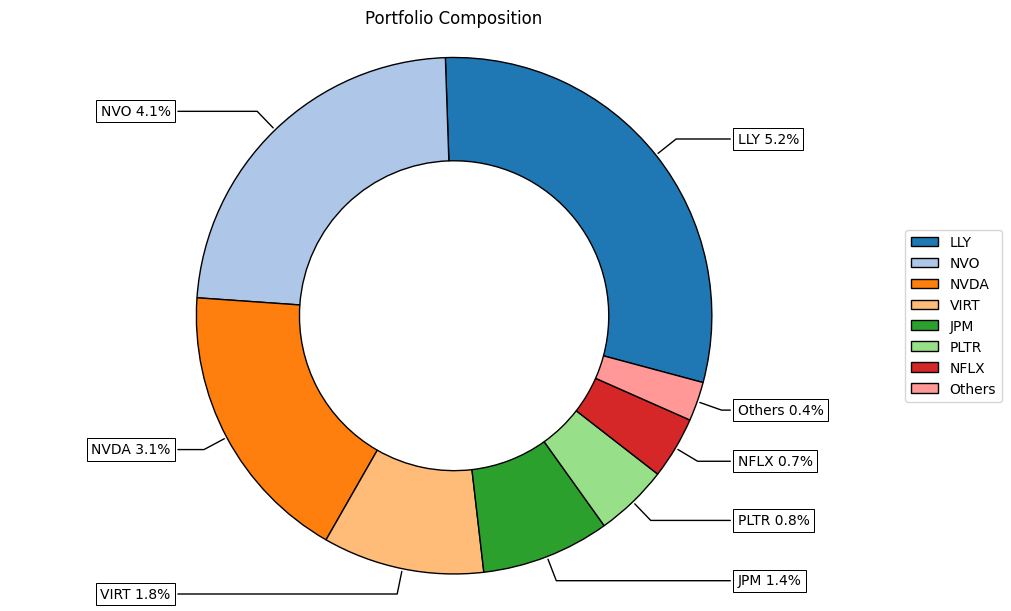

In [96]:

rp.plot_pie (
w = w_constrained_close,
others=0.05,
nrow=25,
height=6,
width=10
)

The portfolio is not simply a list of “the top 5 Sharpe ratio stocks.” Instead, it’s the result of a systematic trade-off:
LLY and NVO dominate because they combine strong returns with low correlation.
NVDA adds high upside from Technology, but capped by volatility.
VIRT and JPM add a bit of Financials exposure, ensuring diversification.
So the top 5 holdings (LLY, NVO, NVDA, VIRT, JPM) represent a balance of return, risk, and diversification under your constraints.

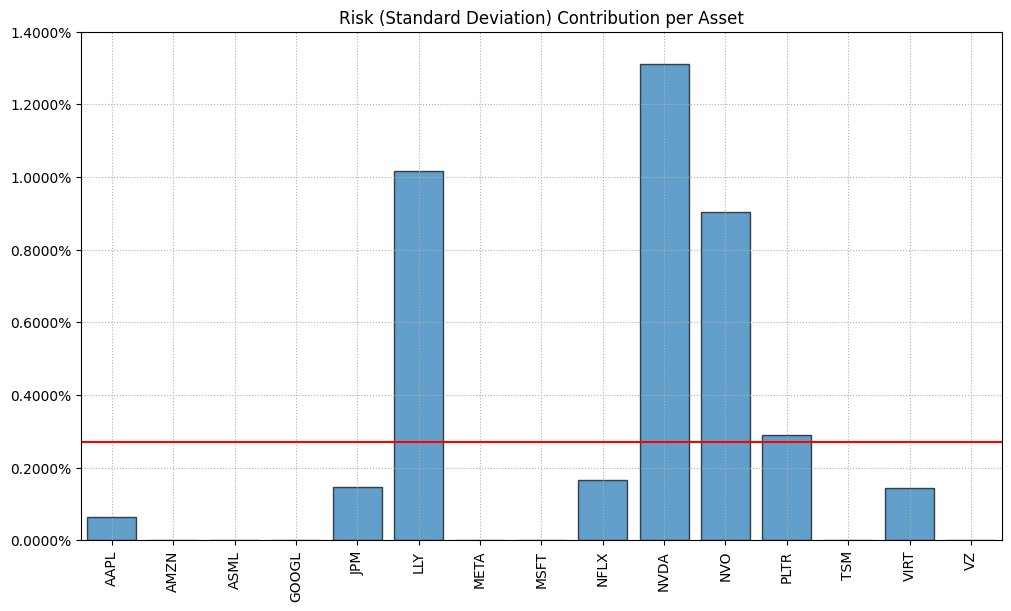

In [97]:
# Extract 'Close' prices and calculate returns
close_prices = prices['Close']
returns = close_prices.pct_change().dropna()

# Calculate covariance matrix directly from returns
cov_matrix = returns.cov()

rp.plot_risk_con(
    w_constrained_close, # Use original weights (descending order by default)
    cov=cov_matrix, # Use the directly calculated covariance matrix
    returns=returns, # Use the returns DataFrame with ticker symbols as columns
    height=6,
    width=10
    )

import matplotlib.pyplot as plt
plt.show()

In [98]:
import numpy as np
import pandas as pd

# Calculate expected returns (µ) from the returns DataFrame
mu = returns.mean()

# Calculate covariance matrix from the returns DataFrame
cov_matrix = returns.cov()

# Calculate volatility (σ = sqrt of variance from diagonal of covariance matrix)
sigma = np.sqrt(np.diag(cov_matrix))
sigma = pd.Series(sigma, index=cov_matrix.index)

# 3. Final weights (from optimization output)
weights = w_constrained["weights"] if "weights" in w_constrained.columns else w_constrained.iloc[:,0]
weights = weights.loc["Close"] # Filter for 'Close' prices weights
weights = weights.rename("Weight")


# 4. Sharpe ratio (µ / σ), no risk-free rate
sharpe = (mu / sigma)

# Set names for concatenation
mu.name = "Expected Return (µ)"
sigma.name = "Volatility (σ)"
sharpe.name = "Sharpe Ratio"

# Combine everything into one summary table
summary = pd.concat([
    mu,
    sigma,
    sharpe,
    (weights * 100).rename("Final Weight (%)")
], axis=1)

# Round for neat display
summary = summary.round(4)

# Show the summary
display(summary)

,Expected Return (µ),Volatility (σ),Sharpe Ratio,Final Weight (%)
AAPL,0.0005,0.0170,0.0321,0.4278
AMZN,0.0006,0.0241,0.0266,0.0000
ASML,0.0003,0.0274,0.0119,0.0000
GOOGL,0.0006,0.0206,0.0292,0.0000
JPM,0.0008,0.0157,0.0496,1.4064
LLY,0.0016,0.0181,0.0888,5.1885
META,0.0013,0.0307,0.0412,0.0000
MSFT,0.0005,0.0173,0.0287,0.0000
NFLX,0.0010,0.0308,0.0326,0.6796
NVDA,0.0026,0.0348,0.0755,3.1144


Top 5 stocks

1. LLY (5.2%)
Strongest expected daily returns.
High Sharpe ratio → excellent standalone performer.
As a Healthcare stock, it also offers diversification away from Technology and Financials.
That’s why the optimizer leaned in heavily here.
2. NVO (4.1%)
Slightly lower Sharpe ratio than some names like PLTR or JPM, but much weaker correlation with the rest of the portfolio.
That means NVO brings independent return streams without amplifying portfolio volatility.
Optimizer values it because it lifts overall portfolio Sharpe, even if its own Sharpe is middle-of-the-pack.
3. NVDA (3.1%)
Extremely strong historical returns, but with high volatility.
Standalone Sharpe is attractive, but not as high as Healthcare.
The optimizer included NVDA, but kept it modest at ~3%, balancing its upside with its risk.
4. VIRT (1.8%)
Lower return profile, but contributes diversification within Financials.
Even with a modest Sharpe, VIRT reduces correlation with other holdings.
Its presence balances sector exposure under your Financials ≤20% cap.
5. JPM (1.4%)
Similar story to VIRT. Not the strongest Sharpe, but Financials add balance to an otherwise Tech + Healthcare-heavy portfolio.
The optimizer included it lightly because its returns aren’t as high, and it correlates with other financial names.